# SETUP


In [1]:
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/student-performance-and-game-play/sample_submission.csv
/kaggle/input/student-performance-and-game-play/train_labels.csv
/kaggle/input/student-performance-and-game-play/train.csv
/kaggle/input/student-performance-and-game-play/test.csv
/kaggle/input/student-performance-and-game-play/jo_wilder_310/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/student-performance-and-game-play/jo_wilder_310/__init__.py
/kaggle/input/student-performance-and-game-play/jo_wilder/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/student-performance-and-game-play/jo_wilder/__init__.py


# LOAD DATASETS

In [2]:
dtypes = {
    'elapsed_time'  : np.int32,
    'event_name'    : 'category',
    'name'          : 'category',
    'level'         : np.uint8,
    'room_coor_x'   : np.float32,
    'room_coor_y'   : np.float32,
    'screen_coor_x' : np.float32,
    'screen_coor_y' : np.float32,
    'hover_duration': np.float32,
    'text'          : 'category',
    'fqid'          : 'category',
    'room_fqid'     : 'category',
    'text_fqid'     : 'category',
    'fullscreen'    : 'category',
    'hq'            : 'category',
    'music'         : 'category',
    'level_group'   : 'category'
}

TRAIN_DATASET_PATH = '/kaggle/input/student-performance-and-game-play/train.csv'
train_df = pd.read_csv(TRAIN_DATASET_PATH, dtype = dtypes)
print(f'train_df.shape = {train_df.shape}')
train_df.head()

train_df.shape = (26296946, 20)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991394,-159.314682,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [3]:
TRAIN_LABELS_DATASET_PATH = '/kaggle/input/student-performance-and-game-play/train_labels.csv'
train_labels_df = pd.read_csv(TRAIN_LABELS_DATASET_PATH)
print(f'train_labels_df.shape = {train_labels_df.shape}')
train_labels_df.head()

train_labels_df.shape = (424116, 2)


,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090312455206810_q1,1
3,20090313091715820_q1,0
4,20090313571836404_q1,1


In [4]:
TEST_DATASET_PATH = '/kaggle/input/student-performance-and-game-play/test.csv'
test_df = pd.read_csv(TEST_DATASET_PATH)
print(f'test_df.shape = {test_df.shape}')
test_df.head()

test_df.shape = (3728, 21)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,...,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group,session_level
0,20090109393214576,0,0,cutscene_click,basic,0,NaN,-413.991405,75.685314,380.0,...,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4,0
1,20090109393214576,1,1965,person_click,basic,0,NaN,-105.991405,-63.314686,688.0,...,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,0
2,20090109393214576,2,3614,person_click,basic,0,NaN,-418.991405,47.685314,375.0,...,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,0
3,20090109393214576,3,5330,person_click,basic,0,NaN,-110.991405,-57.314686,683.0,...,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,0
4,20090109393214576,4,6397,person_click,basic,0,NaN,-110.991405,-57.314686,683.0,...,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,0


## PREPARE DATASETS

### Train dataset

In [5]:
FEATURE_CATS = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid', 'screen_patch_index', 'room_patch_index']
FEATURE_NUMS = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'hover_duration']

def feature_engineer(dataset, verbose = True):
    ds = dataset.copy()

    screen_resolution = (
        np.round(ds['screen_coor_x'].max() - ds['screen_coor_x'].min(), -1),
        np.round(ds['screen_coor_y'].max() - ds['screen_coor_y'].min(), -1)
    )

    gcd = np.gcd(int(screen_resolution[0]), int(screen_resolution[1]))
    aspect_ratio = (int(screen_resolution[0]) // gcd, int(screen_resolution[1]) // gcd)
    aspect_ratio

    if verbose:
        print(f'Screen resolution: {screen_resolution}')
        print(f'Aspect ratio     : {aspect_ratio}')

    ds['screen_patch_index'] = \
        np.minimum(np.floor(ds['screen_coor_x'] / screen_resolution[0] * aspect_ratio[0]), aspect_ratio[0] - 1) + \
        np.minimum(np.floor(ds['screen_coor_y'] / screen_resolution[1] * aspect_ratio[1]), aspect_ratio[1] - 1) * aspect_ratio[0]

    N_ROOM_PATCHES = 8    
    
    ds['room_patch_index'] = \
        np.minimum(np.floor((ds['room_coor_x'] - ds['room_coor_x'].min()) / (ds['room_coor_x'].max() - ds['room_coor_x'].min()) * N_ROOM_PATCHES), N_ROOM_PATCHES - 1) + \
        np.minimum(np.floor((ds['room_coor_y'] - ds['room_coor_y'].min()) / (ds['room_coor_y'].max() - ds['room_coor_y'].min()) * N_ROOM_PATCHES), N_ROOM_PATCHES - 1) * N_ROOM_PATCHES
    

    new_features = []

    temp = ds.groupby(['session_id','level_group'])

    for feature in FEATURE_CATS:
        new_feature = temp[feature].agg('nunique')
        new_feature.name = feature + '_nunique'
        new_features.append(new_feature)

    for feature in FEATURE_NUMS:
        new_feature = temp[feature].agg('mean')
        new_features.append(new_feature)

    for feature in FEATURE_NUMS:
        new_feature = temp[feature].agg('std')
        new_feature.name = feature + '_std'
        new_features.append(new_feature)

    new_feature = temp['elapsed_time'].agg('max') - temp['elapsed_time'].agg('min')
    new_feature.name = 'total_time'
    new_features.append(new_feature)   

    modified_train_df = pd.concat(new_features, axis = 1)
    modified_train_df = modified_train_df.fillna(-1)
    modified_train_df = modified_train_df.reset_index()
    modified_train_df = modified_train_df.set_index('session_id')
    modified_train_df = modified_train_df.sort_index()
    
    return modified_train_df

In [6]:
modified_train_df = feature_engineer(train_df)

del train_df
gc.collect()

modified_train_df.head()

Screen resolution: (1920.0, 1440.0)
Aspect ratio     : (4, 3)


,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,screen_patch_index_nunique,room_patch_index_nunique,elapsed_time,level,...,hover_duration,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std,total_time
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,3,30,7,17,4,22,8.579356e+04,1.945455,...,2389.500000,49246.539458,1.230975,-1.000000,399.296038,129.292411,214.871000,104.082743,3227.370757,194860
20090312431273200,13-22,10,3,49,12,35,4,38,1.040601e+06,17.402381,...,899.925903,126666.129584,2.358652,-1.000000,622.061374,230.370874,240.280218,99.067861,1305.088265,435947
20090312431273200,5-12,10,3,39,11,24,4,17,3.572052e+05,8.054054,...,969.333313,80175.676658,2.096919,-1.000000,357.227701,137.409476,203.268560,120.255453,1316.408315,277750
20090312433251036,0-4,11,4,22,6,11,4,22,9.763342e+04,1.870504,...,1378.750000,67372.714092,1.232616,0.000000,445.980041,156.186242,252.554707,121.062929,2114.876406,233752
20090312433251036,13-22,11,6,73,16,43,4,47,2.498852e+06,17.762529,...,720.384949,777382.529186,1.825923,0.863075,529.575656,234.279590,259.288856,133.345693,1990.705518,2638851


### Train labels dataset

In [7]:
train_labels_df['session']  = train_labels_df['session_id'].apply(lambda id: int(id.split('_q')[0]))
train_labels_df['question'] = train_labels_df['session_id'].apply(lambda id: int(id.split('_q')[1]))
train_labels_df.head()

,session_id,correct,session,question
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


## TRAIN MODEL

In [8]:
N_QUESTIONS = 18
QUESTIONS   = list(range(1, 1 + N_QUESTIONS))
TRAIN_RATIO = 0.8

def train_test_split(dataset, train_ratio = TRAIN_RATIO, random_state = None):
    session_ids = shuffle(modified_train_df.index.unique(), random_state = random_state)
    split_index = min(int(len(session_ids) - 1), int(len(session_ids) * train_ratio))
    
    return dataset.loc[session_ids[:split_index]], dataset.loc[session_ids[split_index:]]

train_x, validate_x = train_test_split(modified_train_df, random_state = 42)
print(f'Train dataset size   : {len(train_x)}')
print(f'Validate dataset size: {len(validate_x)}')

Train dataset size   : 56547
Validate dataset size: 14139


In [9]:
def random_forest_model(max_depth):
    validate_session_ids = validate_x.index.unique()

    train_result_df = pd.DataFrame()
    prediction_df = pd.DataFrame(data = np.zeros((len(validate_session_ids), 18)), index = validate_session_ids)
    models = {}

    for question in QUESTIONS:
        if question <= 3:           # question 1 - 3
            level_group = '0-4'
        elif question <= 13:        # question 4 - 13
            level_group = '5-12'
        elif question <= 18:        # question 14 - 18
            level_group = '13-22'

        t_x = train_x.loc[train_x.level_group == level_group].drop('level_group', axis = 1)
        v_x = validate_x.loc[validate_x.level_group == level_group].drop('level_group', axis = 1)

        t_y = train_labels_df[train_labels_df['question'] == question].set_index('session').loc[t_x.index.values, 'correct']
        v_y = train_labels_df[train_labels_df['question'] == question].set_index('session').loc[v_x.index.values, 'correct']

        random_forest = RandomForestClassifier(max_depth = max_depth, n_estimators = 20, random_state = 42)
        random_forest.fit(t_x, t_y)

        t_y_pred = random_forest.predict(t_x)
        v_y_pred = random_forest.predict(v_x)

        train_result_df = pd.concat([train_result_df, pd.DataFrame({
            'question'          : [question],
            'train_accuracy'    : [accuracy_score(t_y, t_y_pred)],
            'validate_accuracy' : [accuracy_score(v_y, v_y_pred)]
        })], ignore_index=True)

        models[question] = random_forest

        prediction_df.loc[validate_session_ids, question - 1] = v_y_pred.flatten()

    return models, train_result_df.set_index('question'), prediction_df

In [10]:
avg_train_accuracy_scores    = []
avg_validate_accuracy_scores = []
models_by_depth              = {}
predictions_by_depth         = {}

for depth in range(1, 11):
    models, train_result_df, prediction_df = random_forest_model(depth)

    avg_train_accuracy    = train_result_df['train_accuracy'].mean()
    avg_validate_accuracy = train_result_df['validate_accuracy'].mean()

    avg_train_accuracy_scores.append(avg_train_accuracy)
    avg_validate_accuracy_scores.append(avg_validate_accuracy)
    models_by_depth[depth] = models
    predictions_by_depth[depth] = prediction_df

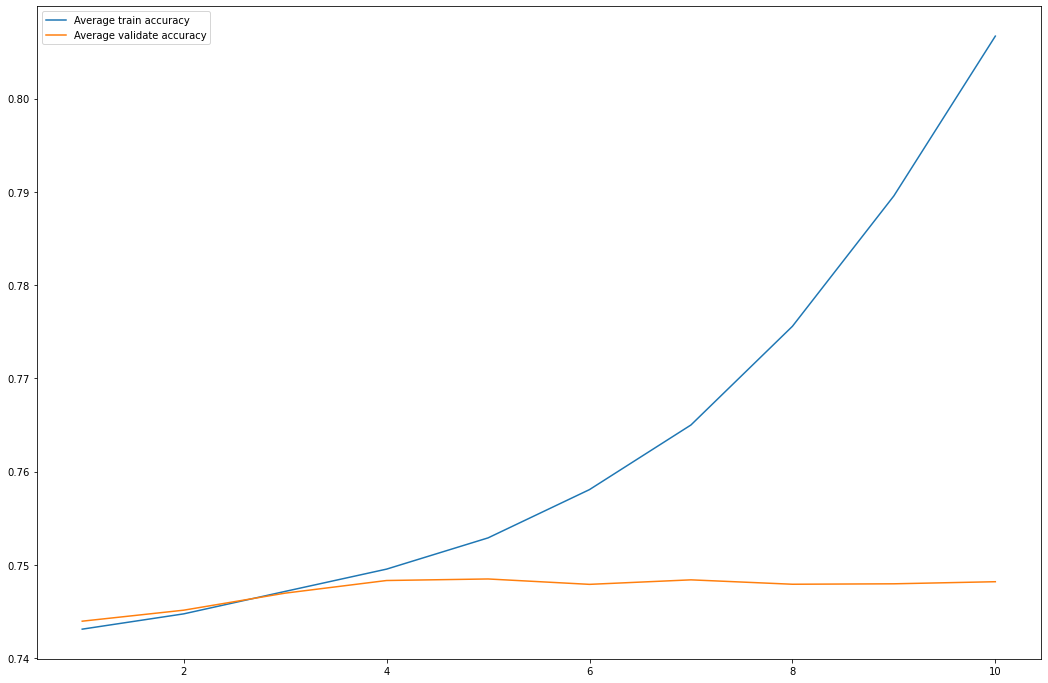

Best depth            : 5
Best average accuracy : 0.7484970648560718


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
session_id,,,,,,,,,,,,,,,,,,
21040610390393572,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
21050211295469356,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
21040509060697396,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
21000413323042570,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
21030219463869456,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


In [11]:
plt.figure(figsize = (18, 12))

plt.plot(np.arange(1, 11, 1), np.array(avg_train_accuracy_scores), label = 'Average train accuracy')
plt.plot(np.arange(1, 11, 1), np.array(avg_validate_accuracy_scores), label = 'Average validate accuracy')

plt.legend()
plt.show()

best_search_depth = np.array(avg_validate_accuracy_scores).argmax() + 1
best_accuracy     = np.array(avg_validate_accuracy_scores).max()

random_forests = models[best_search_depth]
prediction_df  = predictions_by_depth[best_search_depth]

print(f'Best depth            : {best_search_depth}')
print(f'Best average accuracy : {best_accuracy}')
prediction_df.head()

## SUBMISSION

In [12]:
import jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

In [13]:
limits = {'0-4': (1,4), '5-12': (4,14), '13-22': (14,19)}

for (test, sample_submission) in iter_test:
    test_df = feature_engineer(test, verbose = False)
    level_groups = test_df['level_group'].unique()
    for level_group in level_groups:
        a,b = limits[level_group]
        for question in range(a, b):
            model = random_forests[question]
            test_ds = test_df[test_df['level_group'] == level_group].drop('level_group', axis = 1)
            predictions = model.predict(test_ds)
            mask = sample_submission['session_id'].str.contains(f'q{question}')
            n_predictions = predictions.astype(int)
            sample_submission.loc[mask,'correct'] = n_predictions.flatten()

    env.predict(sample_submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has featu

In [14]:
! head submission.csv

session_id,correct
20090109393214576_q1,0
20090109393214576_q2,0
20090109393214576_q3,1
20090109393214576_q4,1
20090109393214576_q5,1
20090109393214576_q6,0
20090109393214576_q7,0
20090109393214576_q8,0
20090109393214576_q9,1
